# dsci100_team26_project

From the Jupyter Server Menu:
git -> clone_repository -> enter github info -> done

I. Introduction <br>
&nbsp; a. Brief Overview of the Project  <br>
&nbsp; b. Brief Literature Review  <br>
&nbsp; c. Describing the Data Set and how we will use it  <span style="color: green">[CODE - put in appendix]</span><br> 
II. Methods <br>
&nbsp; a. Methodology summary  <br>
&nbsp; b. Preparation (Loading, Wrangling, and Cleaning the Data)  <br>
&nbsp;
&nbsp;
&nbsp; Lebron James Example <br>
&nbsp; c. Exploratory Data Analysis  <br>
&nbsp; d. (Hypothesized) Initial Model Parameter Selection  <br>
&nbsp; e. Optimizing training-model via Forward Model Selection  <br>
&nbsp; d. Optimizing training-model using all Param subsets for Selection <span style="color: red">[CODE - put in appendix]</span>  <br>
III. Results <br>
&nbsp; a. Results Overview  <br>
&nbsp; b. Best Model (probably from Param Selection)  <br>
&nbsp; c. Testing best model on the testing data <br>
&nbsp; d. Visualization of results <br>
IV. Sources <br>
V. Appendices


Create R libraries



1. Finish Methods 
    Build initial classification
        Use forward selection 
        Use all sub-set selection
    Change to trying to predict Guards vs. Forwards
    Take initial date, change positions, re-split, re-visualize training data, then build knn model with all subset selection
    

In [1]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1     ✔ rsample      1.1.0
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.3     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.3     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() ma

# Abstract

We build four classification models. First, we  improving on an initial hypothesis 

# Introduction <a name="introduction"></a>

This project is inspired by the ambiguity of basketball positions, based on how the game is played in National-Basketball-Association (NBA) regulation basketball, and the aptness of this question as a classification exercise.

In NBA Basketball, there are no players consistently on offense or defense, unlike Football/Soccer and American Football and Baseball. Instead, when possession of the ball changes teams, the same players who were just on defense immediately begin playing offense, and vice-versa. This makes the role of each player harder to understand for someone watching basketball for the first time. In fact, many first-time basketball viewers may not realize that there are positions at all, and junior/recreational basketball teams frequently play without positions. The goal of our work here is to suggest whether these positions exist largely as formalities, or if <u>players' positions can be classified by their past gameplay statistics</u>.

<b>Background</b>

Below is a table describing the 5 different basketball positions, and an accompanying figure showing where each position is usually found.

<br>

| Position      | Description |
| ----------- | ----------- |
| Point Guard (PG)      | Text       |
| Shooting Guard (SG)   | Text        |
| Small Forward (SF)   | Text        |
| Power Forward (PF)   | Text        |
| Center (C)   | Text        |

<br>


<img align="center"
     src="https://upload.wikimedia.org/wikipedia/commons/a/ac/Basketball_Positions.png" width="400" height="400"
     alt="imageinfo" 
     style=""/>





<br><br><br>
<b> Literature Review </b>


<br><br><br>
<b> Data </b>

The data we are working with comes from basketball-reference.com ... 


# Methods

Before starting, we ensure the appropriate libraries are installed, and a seed is set in order to ensure the reproducibility of this notebook. 

We  begin our investigation by loading and wrangling the season statistics. From the raw data, we select 7 non-derived (no ratios, percentages, etc.), gameplay statistics. Throughout this notebook these statistics will be referred to by their abbreviations given below.

| Abbreviation      | Full | Description (# = number of times a player ...) | 
| ----------- | ----------- | ----------- 
| BLK         | Blocks      | # blocks the opposing team from scoring
| AST         | Assists     | # passes to another player on their team who scores
| STL         | Steals      | # steals the ball from the opposing team
| PF       | Personal Fouls | # fouls a member of the opposing team
| TRB      | Total Rebounds | # gains possession of the ball after an attempted basket (from their team or opposing)
| MP       | Minutes Played | # plays for a whole minute
| 3PA     | 3 Point Attempts| # shoots from outside the 3 - point line (far from the basket)

<br>

Next, we load and wrangle additional data containing every NBA player's height and weight, and merge this with the season statistics, resulting in a new dataset that has the cumulative statistics for *each position* that each player has played in the NBA from 2000 to 2015, and their height and weight (which doesn't vary between position.). We divide each player's cumulative gameplay statistics by the total minutes they've played throughout either their career or the years 2000 - 2015 (whichever is less) to account for the varying game time of each player in the time frame under consideration.

We then conduct an exploratory analysis and build an initial classification model. Finding this initial model's low accuracy on training data unsatisfying, we try to optimize it using the *forward selection* technique to select the best combination of parameters. This does little to improve its accuracy, so we then develop a second classification model used to predict between just two types of positions: Guards and Forwards. This second model performs significantly better on its training data, so we continue with it to the testing stage. We discuss our different models and the implication of their different accuracy to our research question in the [Discussion](#discussion) section.

## Setup

Below we load the typical DSCI100 packages, the viridis library to ensure our visualizations are accessible, and three additional mini packages that we purpose-built for this project: 
- `bball_scrape` : collects data from *basketball-reference.com* (we have followed the protocol set forth in <a href="https://datasciencebook.ca/reading.html#obtaining-data-from-the-web">Chapter 2 of *Data Science: A First Introduction*</a> to ensure we are webscraping ethically.) 
- `forward_selection` : optimizies which predictor variables are used in our classification model
- `best_subset_selection` : further optimizes which predictor variables to use

We include the code for these packages in the appendices. Because the techniques used in these packages were not discussed in class we do not devote many words to describing them in this notebook, but we do include a README.md describing each of them in their respective github repositories, which are listed alongside their code in the [appendices](#appendices).

In [10]:
library(tidyverse)
library(tidymodels)
library(viridis)

# library(devtools)
# install_github("james-magee/bball_scrape")
# install_github("james-magee/forward_selection")
# install_github("james-magee/best_subset_selection")

# library(bball_scrape)
# library(forward_selection)
# library(best_subset_selection)

set.seed(2023)

## Loading and Wrangling the Data

To begin our analysis, we need data! We break this process into 4 steps:
1. Load the raw data from our [webscraping library](#appendix1)
2. Filter rows, select columns, and rename columns: 
    * Filter the raw data to remove:
        * rows where `MP == 0` (minutes played). We will later divide each predictor column by `MP` so it can't be zero.
        * rows where `Year` is outside the 2000-2015 range.
        * rows where `Pos` is not one of the 5 common positions in Basketball today (see [Methods](#methods))
    * Select the columns we are interested in (see [Methods](#methods))
    * Rename non-predictor columns to be lowercase, and convert the `Pos` column from type character-string to factor. 
3. Consolidate rows containing statistics for the same player and position.
4. Load and wrangle the player height and weight data
5. Merge the player height and weight data with the season statistics

In [18]:
# 1

# raw_season_data <- get_season_data(2000:2020)
# head(raw_season_data)

# PREVIOUS:
#
urlfile_1 <- "https://raw.githubusercontent.com/cass12345/ddssccii/main/Seasons_Stats.csv"
raw_season_data <- read_csv(url(urlfile_1), show_col_types = FALSE)

raw_season_data |> 
    select(2:20) |>   # Select the first 20 columns, after the id
    drop_na() |>      # Drop rows with NA observatinos
    head()            # Show just the first 5 rows

New names:
• `` -> `...1`


Year,Player,Pos,Age,Tm,G,GS,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1980,Tiny Archibald*,PG,31,BOS,80,80,2864,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7
1980,Larry Bird*,PF,23,BOS,82,82,2955,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0
1980,M.L. Carr,SF,29,BOS,82,7,1994,14.6,0.526,0.054,0.316,6.0,12.3,9.2,10.7,2.8,1.0,14.1
1980,Don Chaney,SG,33,BOS,60,0,523,7.8,0.402,0.032,0.222,6.7,8.8,7.8,9.3,2.8,1.2,13.7
1980,Dave Cowens*,C,31,BOS,66,55,2159,14.8,0.477,0.013,0.131,6.6,20.7,13.8,13.4,1.5,1.6,9.9
1980,Eric Fernsten,PF,26,BOS,56,0,431,14.4,0.497,0.000,0.340,10.5,14.3,12.4,8.7,1.8,1.6,10.2


In [1]:
# 2 

filtered_data <- raw_season_data |>
    filter(MP != 0) |>
    filter(Pos %in% c("PF","PG","SF","SG","C")) |>
    filter(Year >= 2000 & Year <= 2015)

selected_data <- filtered_data |>
    select(Player, Pos, BLK, AST, TRB, STL, MP, "3PA", PF)

renamed_data <- selected_data |>
    rename(name = Player) |>
    rename(three_PA = "3PA") |>
    mutate(pos = as_factor(Pos), 
           .keep = "unused", 
           .after = 1)

renamed_data |> head()

ERROR: Error in as.ts(x): object 'raw_season_data' not found


In [27]:
# 4

season_data <- season_data |>
    group_by(name, pos) |>
    summarize(across(.cols  = c(BLK, AST, TRB, STL, MP, three_PA, PF), 
                     .fns   = list(sum=sum),
                     .names = "{.col}"),
              .groups = "keep") |>
    mutate(across(.cols  = c(BLK, AST, TRB, STL, three_PA, PF),
                  .fns   = list(function(.){return(./MP)}),
                  .names = "{.col}_per_MP"),
           .keep = "unused")

ERROR: [1m[33mError[39m in `summarize()`:[22m
[1m[22m[33m![39m Problem while computing `..1 = across(...)`.
[36mℹ[39m The error occurred in group 0: character(0), character(0).
[1mCaused by error in `across()`:[22m
[33m![39m Can't subset columns that don't exist.
[31m✖[39m Column `BLK` doesn't exist.



<br>



### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Loading Player Height, Weight, and Merging Dataframes

So far we've loaded and cleaned the season statistics for each player in the NBA from 2000 to 2015. We're almost done with finalizing our dataset, we just need to match the position height and weight to each player.

In [28]:
# NEW:
# raw_player_data <- get_all_players()


# PREVIOUS:
#
urlfile_2 <- "https://raw.githubusercontent.com/cass12345/ddssccii/main/player_data.csv"
raw_player_data <- read_csv(url(urlfile_2), show_col_types = FALSE)
head(raw_player_data)

name,year_start,year_end,position,height,weight,birth_date,college
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
Alaa Abdelnaby,1991,1995,F-C,6-10,240,"June 24, 1968",Duke University
Zaid Abdul-Aziz,1969,1978,C-F,6-9,235,"April 7, 1946",Iowa State University
Kareem Abdul-Jabbar,1970,1989,C,7-2,225,"April 16, 1947","University of California, Los Angeles"
Mahmoud Abdul-Rauf,1991,2001,G,6-1,162,"March 9, 1969",Louisiana State University
Tariq Abdul-Wahad,1998,2003,F,6-6,223,"November 3, 1974",San Jose State University
Shareef Abdur-Rahim,1997,2008,F,6-9,225,"December 11, 1976",University of California


<br>

Wrangling this data will be easier. All we have to do is convert the height from the "<feet>-<inches>" format to a numerical format, and select the columns we are interested in. Whether we use inches or centimeters doesn't matter since we will be normalizing each height and weight observation in our classification recipe. We convert the height string to a number by separating the feet and inches into their own columns, then redefining `height` using `mutate` to equal `(feet * 12) + inches` .

In [29]:
player_data <- raw_player_data |>
    separate(col  = height,
             into = c("feet","inches"),
             sep  = "-",
             convert = TRUE)|>
    mutate(height = feet * 12  + inches) |>
    select(name, weight, height)

head(player_data)

name,weight,height
<chr>,<dbl>,<dbl>
Alaa Abdelnaby,240,82
Zaid Abdul-Aziz,235,81
Kareem Abdul-Jabbar,225,86
Mahmoud Abdul-Rauf,162,73
Tariq Abdul-Wahad,223,78
Shareef Abdur-Rahim,225,81


<br>

Now we just have to merge the dataframes.

In [30]:
final_dataset <- merge(x = season_data, y = player_data, by.x = "name", by.y = "name") |>
    drop_na()

head(final_dataset)

,name,pos,BLK_per_MP,AST_per_MP,TRB_per_MP,STL_per_MP,three_PA_per_MP,PF_per_MP,weight,height
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,A.C. Green,PF,0.007784431,0.03562874,0.23922156,0.02485030,0.002994012,0.07365269,220,81
2,A.J. Bramlett,C,0.000000000,0.00000000,0.36065574,0.01639344,0.000000000,0.21311475,227,82
3,A.J. Guyton,PG,0.009630819,0.11797753,0.06420546,0.01605136,0.154895666,0.04654896,180,73
4,A.J. Price,SG,0.000000000,0.13131313,0.10101010,0.01010101,0.222222222,0.05050505,181,74
5,A.J. Price,PG,0.002166586,0.14443909,0.09605200,0.03153587,0.174530573,0.05946076,181,74
6,Aaron Brooks,PG,0.006230943,0.14450484,0.07888108,0.02744266,0.165186265,0.08743206,161,72


<br><br><br>

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Splitting the Train and Test Data

Splitting our data into separate testing and training dataframes will be important for us to test the accuracy of our classification model after we have made it.

In [29]:
data_split <- initial_split(final_dataset, prop = 0.75, strata = pos)
player_train <- training(data_split)
player_test <- testing(data_split)

ERROR: Error in eval_select_impl(NULL, .vars, expr(c(!!!dots)), include = .include, : object 'final_dataset' not found


## Exploratory Analysis

In [32]:
player_train |>
    pivot_longer(3:10, names_to = "key", values_to = "value") |>
    head()

name,pos,key,value
<chr>,<fct>,<chr>,<dbl>
Aaron Gray,C,BLK_per_MP,0.0234669028
Aaron Gray,C,AST_per_MP,0.0555678548
Aaron Gray,C,TRB_per_MP,0.3114899269
Aaron Gray,C,STL_per_MP,0.0250166039
Aaron Gray,C,three_PA_per_MP,0.0008855435
Aaron Gray,C,PF_per_MP,0.1762231570


In [218]:
mean(player_train[,"height"])

[1] 79.02145

In [222]:
player_train |> 
    mutate(across(where(is.numeric), scale)) |>
    pivot_longer(3:10, names_to = "key", values_to = "value")

name,pos,key,value
<chr>,<fct>,<chr>,"<dbl[,1]>"
Aaron Gray,C,BLK_per_MP,0.14997935
Aaron Gray,C,AST_per_MP,-0.33905426
Aaron Gray,C,TRB_per_MP,1.58364439
Aaron Gray,C,STL_per_MP,-0.30953901
Aaron Gray,C,three_PA_per_MP,-0.96106335
Aaron Gray,C,PF_per_MP,1.52743366
Aaron Gray,C,weight,1.88222936
Aaron Gray,C,height,1.42430559
Adam Keefe,C,BLK_per_MP,0.07018428


In [28]:
options(repr.plot.width = 18, repr.plot.height = 15)

# OPTIONAL :     # select(!height & !weight) |>
player_train |> 
    mutate(across(where(is.numeric), scale)) |>
    pivot_longer(3:10, names_to = "key", values_to = "value") |>
    filter(value < 3 & value > -3) |>
    ggplot(aes(x = value, fill = pos)) +
    geom_histogram(bins = 25, alpha = 0.75) +
    labs(x = "Predictor Variable (scaled)", y = "Frequency (count)", title="Scaled Season Statistics Predictors by Position", fill = "Position") +
    facet_wrap(~key, ncol = 2, scale = "free_y") +
    scale_fill_viridis(discrete=TRUE) +
    theme(text = element_text(size = 18))

ERROR: Error in mutate(player_train, across(where(is.numeric), scale)): object 'player_train' not found


### Next

## Initial Clasification Model

In [ ]:
ball_recipe1 <- recipe(pos ~ BLK_per_MP + AST_per_MP + TRB_per_MP + three_PA_per_MP + weight + height, 
                       data = player_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())


ks <- tibble(neighbors = seq(from = 80, to = 100, by = 1))

ball_vfold1 <- vfold_cv(player_train, v = 5, strata = pos)

ball_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

ball_fit1 <- workflow() |>
    add_recipe(ball_recipe1) |>
    add_model(ball_spec1) |>
    tune_grid(resamples = ball_vfold1, grid = ks) |>
    collect_metrics()

ball_fit1

## Second Classification Model

In [56]:
guard_or_forward <- function (position) {
    print(position)
    if (toString(position) %in% c("C", "SF", "PF")) {
        return("F")
    } else {
        return("G")
    }
}

player_train |>
    rowwise() |>
    mutate(x = guard_or_forward(pos)) |>
    mutate(pos = as_factor(pos))

In [44]:
head(player_train)

,name,pos,BLK_per_MP,AST_per_MP,TRB_per_MP,STL_per_MP,three_PA_per_MP,PF_per_MP,weight,height
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8,Aaron Gray,C,0.02346690,0.05556785,0.3114899,0.02501660,8.855435e-04,0.17622316,270,84
18,Adam Keefe,C,0.02152318,0.05629139,0.2251656,0.02814570,1.655629e-03,0.14900662,230,81
21,Adonal Foyle,C,0.09331758,0.02640904,0.2623186,0.01991225,8.437395e-05,0.11778603,250,82
29,Al Horford,C,0.03446831,0.07934893,0.2721561,0.02477410,3.889654e-03,0.07396326,245,82
38,Alan Henderson,C,0.02172840,0.02518519,0.2641975,0.02074074,9.876543e-04,0.11160494,235,81
42,Aleksandar Radojevic,C,0.01973684,0.04605263,0.2368421,0.01315789,0.000000e+00,0.24342105,250,87


In [72]:
forwards <- player_train |>
    filter(pos %in% c("C", "SF", "PF")) |>
    mutate(pos = "G")

guards <- player_train |>
    filter(pos %in% c("PG", "SG")) |>
    mutate(pos = "F")

f_g_data <- rbind(forwards, guards)

In [71]:
ball_recipe1 <- recipe(pos ~ BLK_per_MP + AST_per_MP + TRB_per_MP + three_PA_per_MP + weight + height, 
                       data = f_g_data) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())


ks <- tibble(neighbors = seq(from = 2, to = 150, by = 1))

ball_vfold1 <- vfold_cv(f_g_data, v = 5, strata = pos)

ball_spec1 <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

ball_fit1 <- workflow() |>
    add_recipe(ball_recipe1) |>
    add_model(ball_spec1) |>
    tune_grid(resamples = ball_vfold1, grid = ks) |>
    collect_metrics()



In [75]:
ball_fit1

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.8454259,5,0.0104625388,Preprocessor1_Model001
2,roc_auc,binary,0.8999211,5,0.0070450402,Preprocessor1_Model001
3,accuracy,binary,0.8744479,5,0.0090553313,Preprocessor1_Model002
3,roc_auc,binary,0.9230325,5,0.0031075916,Preprocessor1_Model002
4,accuracy,binary,0.8744479,5,0.0090553313,Preprocessor1_Model003
4,roc_auc,binary,0.9377420,5,0.0037115073,Preprocessor1_Model003
5,accuracy,binary,0.8794953,5,0.0072211502,Preprocessor1_Model004
5,roc_auc,binary,0.9435718,5,0.0038846270,Preprocessor1_Model004
6,accuracy,binary,0.8794953,5,0.0072211502,Preprocessor1_Model005


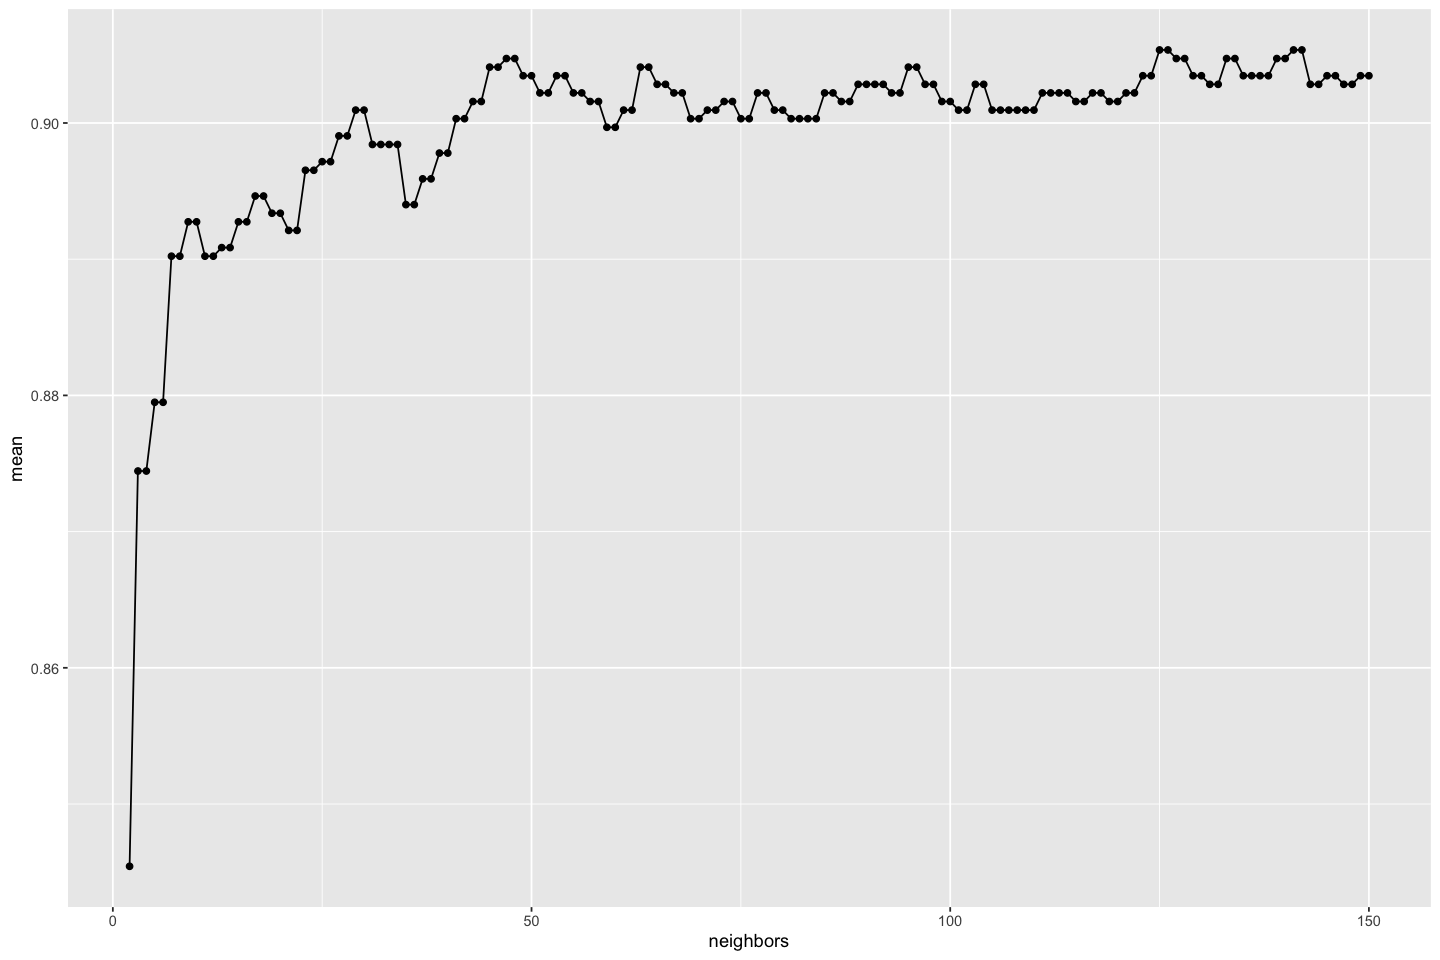

In [73]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(ball_fit1 |> filter(.metric == "accuracy"), aes(x = neighbors, y = mean)) + geom_point() + geom_line()

## Next

In [20]:
# Exploratory Analysis
    # copy from earlier project...

In [21]:
# Initial Classification Model
    # k-nn plot

In [22]:
# Optimizing using Forward-Selection
    # external library +
    # k-nn plot

In [23]:
# Optimizing using All-Subset-Selection

In [24]:
# Settling: can we at least predict if a player is a Gaurd or Forward?
    # optimize using all-subset-selection
    # visualize results with two best parameters

# Discussion

# Sources

# Appendices